This project is dedicated to exploring and implementing predictive models for stock price forecasting using Machine Learning (ML) and Deep Learning (DL) techniques. It engages with a variety of approaches, including Linear Regression, Decision Trees, Random Forest, and notably, Deep Learning through Recurrent Neural Networks (RNN), with a focus on Long Short-Term Memory (LSTM) networks. Our analysis is centered around the New York Stock Exchange Composite Index (NYA), utilizing a dataset  to demonstrate the precision of these advanced technological approaches in predicting stock prices accurately.

In [1]:

# Commented out IPython magic to ensure Python compatibility.
from google.colab import drive
drive.mount('/content/drive')
# %cd /content/drive/My Drive/Colab Notebooks/time
import numpy as np # linear algebra
import pandas as pd

import numpy as np  # For numerical computations
import numpy.polynomial.polynomial as poly  # Polynomial calculations
import pandas as pd  # Data handling
import datetime as dt  # Handling dates and times
import seaborn  # Data visualization
import matplotlib.pylab as plt  # Plotting
import os, random, shutil, glob  # System and file operations

# TensorFlow and Keras for ML models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Scikit-learn for data splitting and model evaluation
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import itertools  # For creating iterators


Mounted at /content/drive


# 1. Machine learning

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/time
import numpy as np # linear algebra
import pandas as pd


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/time


Decision Tree Score: 0.7973522670100477
Linear Regression Score: 0.8281145573435111
Random Forest Score: 0.7990503469636991


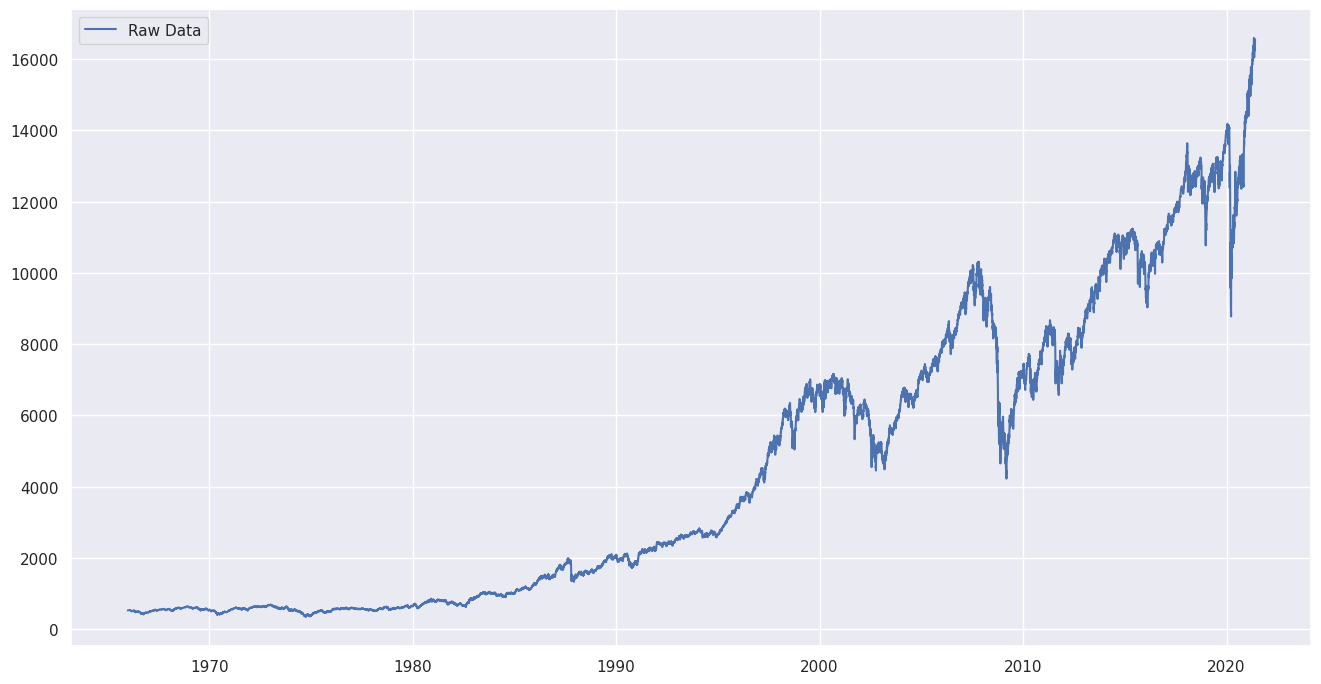

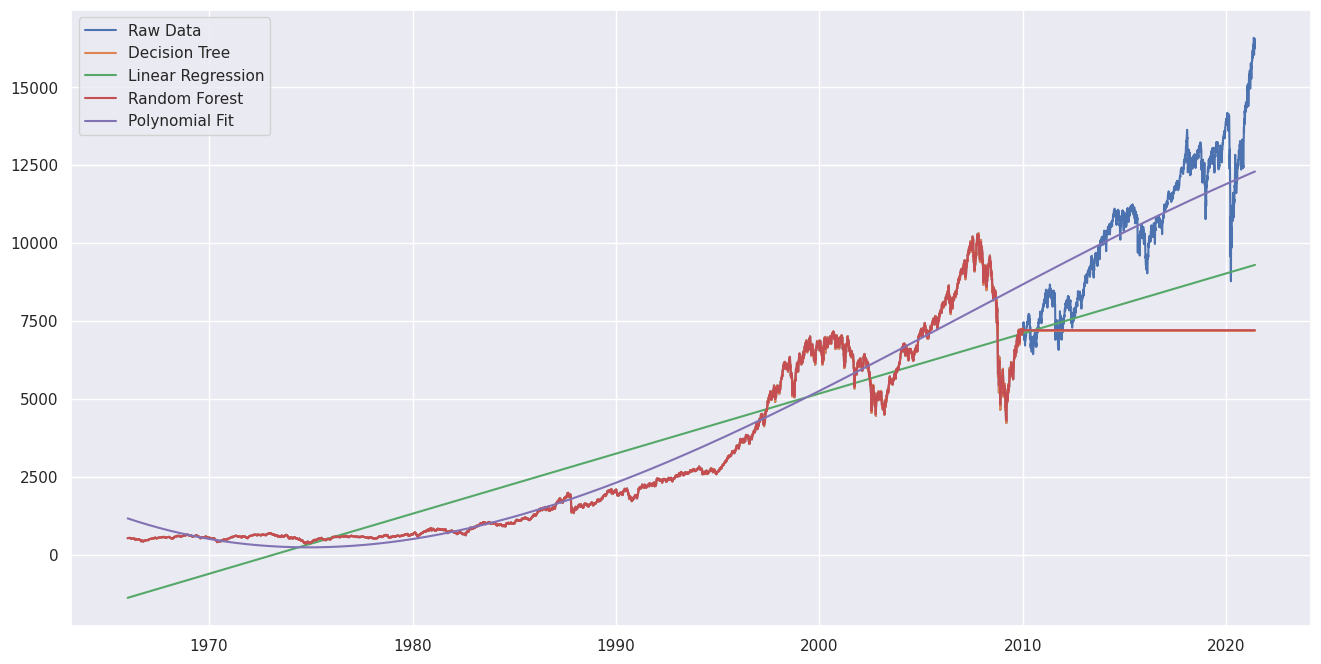

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import datetime as dt
import numpy.polynomial.polynomial as poly

# Set plot style and dimensions
sns.set(rc={'figure.figsize':(16, 8.27)})

# Load data and convert date format
data = pd.read_csv('indexData.csv')
data["Date"] = pd.to_datetime(data["Date"])

# Filter data for NYA index and sort by date
nya_data = data[data["Index"] == 'NYA'].sort_values('Date')

# Plot raw NYA Close data
plt.plot(nya_data["Date"], nya_data["Close"], label='Raw Data')
plt.legend()

# Prepare data for modeling
nya_cleaned = nya_data[['Date', 'Close']].dropna()

# Split data into training and testing sets based on date
training_data = nya_cleaned[nya_cleaned.Date < "2010-01-01"].copy()
testing_data = nya_cleaned[nya_cleaned.Date >= "2010-01-01"].copy()

# Convert date to ordinal for model training
training_data['Date'] = training_data['Date'].apply(lambda x: x.toordinal())
X_train = training_data['Date'].values.reshape(-1, 1)
y_train = training_data['Close']

# Define and train models
decision_tree = DecisionTreeRegressor(criterion='squared_error', max_depth=50).fit(X_train, y_train)
linear_regression = LinearRegression().fit(X_train, y_train)
random_forest = RandomForestRegressor(n_estimators=100).fit(X_train, y_train)

# Prepare full data for predictions
X_all = nya_cleaned['Date'].apply(lambda x: x.toordinal()).values.reshape(-1, 1)

# Make predictions
pred_tree = decision_tree.predict(X_all)
pred_linear = linear_regression.predict(X_all)
pred_forest = random_forest.predict(X_all)

# Polynomial fit
X_poly = np.array(training_data['Date'])
y_poly = np.array(training_data['Close'])
poly_coefficients = poly.polyfit(X_poly, y_poly, 3)
X_full = np.array(nya_cleaned['Date'].apply(lambda x: x.toordinal()))
poly_fit = poly.polyval(X_full, poly_coefficients)
X_full_dates = [dt.datetime.fromordinal(int(date)) for date in X_full]

# Plot all predictions
plt.figure(figsize=(16, 8))
plt.plot(nya_cleaned['Date'], nya_cleaned['Close'], label='Raw Data')
plt.plot(nya_cleaned['Date'], pred_tree, label='Decision Tree')
plt.plot(nya_cleaned['Date'], pred_linear, label='Linear Regression')
plt.plot(nya_cleaned['Date'], pred_forest, label='Random Forest')
plt.plot(X_full_dates, poly_fit, label='Polynomial Fit')
plt.legend()

# Optional: Model performance
print("Decision Tree Score:", decision_tree.score(X_all, nya_cleaned['Close']))
print("Linear Regression Score:", linear_regression.score(X_all, nya_cleaned['Close']))
print("Random Forest Score:", random_forest.score(X_all, nya_cleaned['Close']))


In [4]:

# Calculate and print the Mean Squared Error
mse_tree = mean_squared_error(nya_cleaned['Close'], pred_tree)
mse_linear = mean_squared_error(nya_cleaned['Close'], pred_linear)
mse_forest = mean_squared_error(nya_cleaned['Close'], pred_forest)

print("Decision Tree MSE:", mse_tree)
print("Linear Regression MSE:", mse_linear)
print("Random Forest MSE:", mse_forest)

Decision Tree MSE: 3365609.65181405
Linear Regression MSE: 2854704.053559251
Random Forest MSE: 3337407.6374256406


In [ ]:
def split_sequence(sequence, input_steps, forecast_horizon):
        inputs, outputs = [], []
        for i in range(len(sequence)):
            end_idx = i + input_steps
            out_end_idx = end_idx + forecast_horizon
            if out_end_idx > len(sequence):
                break
            seq_input, seq_output = sequence[i:end_idx], sequence[end_idx:out_end_idx]
            inputs.append(seq_input)
            outputs.append(seq_output)
        return np.array(inputs), np.array(outputs)

In [ ]:
def train_lstm_model(train_prices, num_input_steps, num_forecast_steps, num_features=1):
    """
    Trains an LSTM model.

    Parameters:
    - train_prices: Array of training data prices.
    - num_input_steps: The number of steps to use as input for the model.
    - num_forecast_steps: The number of steps to predict.
    - num_features: The number of features used for training (default is 1 for 'Close' prices).

    Returns:
    - lstm_model: The trained LSTM model.
    - training_history: History object containing training details.
    """


    # Splitting the training data into sequences
    train_inputs, train_targets = split_sequence(train_prices, num_input_steps, num_forecast_steps)
    train_inputs = train_inputs.reshape((train_inputs.shape[0], train_inputs.shape[1], num_features))

    # Building the LSTM model
    lstm_model = Sequential([
        LSTM(200, activation='relu', return_sequences=True, input_shape=(num_input_steps, num_features)),
        LSTM(200, activation='relu'),
        Dense(num_forecast_steps)
    ])

    # Compiling the model
    lstm_model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['accuracy'])
    lstm_model.summary()
    # Training the model
    training_history = lstm_model.fit(train_inputs, train_targets, epochs=10, verbose=2, validation_split=0.33)

    return lstm_model, training_history


In [ ]:
def evaluate_and_plot_lstm_model(model, test_prices, num_input_steps, num_forecast_steps, testing_data):
    """
    Evaluates an LSTM model on the test set and plots the results.

    Parameters:
    - model: The trained LSTM model.
    - test_prices: Array of testing data prices.
    - num_input_steps: The number of input steps the model was trained with.
    - num_forecast_steps: The number of forecast steps the model predicts.
    - testing_data: DataFrame containing the testing data with 'Date' for plotting.
    """

    num_features = 1  # Assuming we are only using 'Close' prices

    # Preparing the test data sequences
    test_inputs, test_targets = split_sequence(test_prices, num_input_steps, num_forecast_steps)
    test_inputs = test_inputs.reshape((test_inputs.shape[0], test_inputs.shape[1], num_features))

    # Making predictions on the test data
    test_predictions = model.predict(test_inputs, verbose=0)

    # Plotting the actual vs. predicted prices
    plot_dates = testing_data['Date'][num_input_steps + num_forecast_steps - 1:].reset_index(drop=True)
    plt.figure(figsize=(10, 6))
    plt.plot(plot_dates, test_prices[num_input_steps + num_forecast_steps - 1:], 'b-', label='Actual Prices')
    plt.plot(plot_dates, test_predictions.mean(axis=1), 'r-', label='Predicted Prices Mean')
    plt.title('Actual vs. Predicted Prices')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

    # Optionally return evaluation metrics
    r2 = r2_score(test_targets.reshape(-1), test_predictions.reshape(-1))
    mse = mean_squared_error(test_targets.reshape(-1), test_predictions.reshape(-1))
    print(f'R2 Score: {r2}')
    print(f'Mean Squared Error: {mse}')

    return r2, mse


In [ ]:
lstm_model, training_history = train_lstm_model(training_data['Close'].to_numpy(), 3, 2)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 3, 200)            161600    
                                                                 
 lstm_11 (LSTM)              (None, 200)               320800    
                                                                 
 dense_4 (Dense)             (None, 2)                 402       
                                                                 
Total params: 482802 (1.84 MB)
Trainable params: 482802 (1.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
232/232 - 11s - loss: 557771.3125 - accuracy: 0.5026 - val_loss: 17357.1113 - val_accuracy: 0.4726 - 11s/epoch - 47ms/step
Epoch 2/10
232/232 - 8s - loss: 336.9355 - accuracy: 0.5013 - val_loss: 12987.1436 - val_accuracy: 0.4893 - 8s/epoch - 34ms/step
Epoch 3/10
232/232 

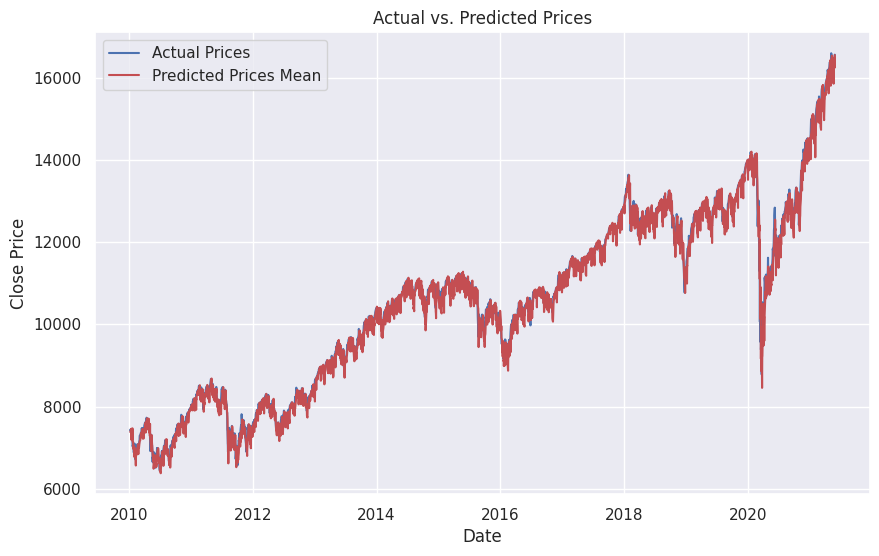

R2 Score: 0.9927369369825455
Mean Squared Error: 35319.6055344062


In [ ]:
r2, mse = evaluate_and_plot_lstm_model(lstm_model, testing_data['Close'].to_numpy(), 3, 2, testing_data)


In [ ]:
lstm_model, training_history = train_lstm_model(training_data['Close'].to_numpy(), 10, 1)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 10, 200)           161600    
                                                                 
 lstm_13 (LSTM)              (None, 200)               320800    
                                                                 
 dense_5 (Dense)             (None, 1)                 201       
                                                                 
Total params: 482601 (1.84 MB)
Trainable params: 482601 (1.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
232/232 - 26s - loss: 320407.7188 - accuracy: 0.0000e+00 - val_loss: 78382.1484 - val_accuracy: 0.0000e+00 - 26s/epoch - 110ms/step
Epoch 2/10
232/232 - 14s - loss: 418.6075 - accuracy: 0.0000e+00 - val_loss: 114818.8906 - val_accuracy: 0.0000e+00 - 14s/epoch - 62ms/step

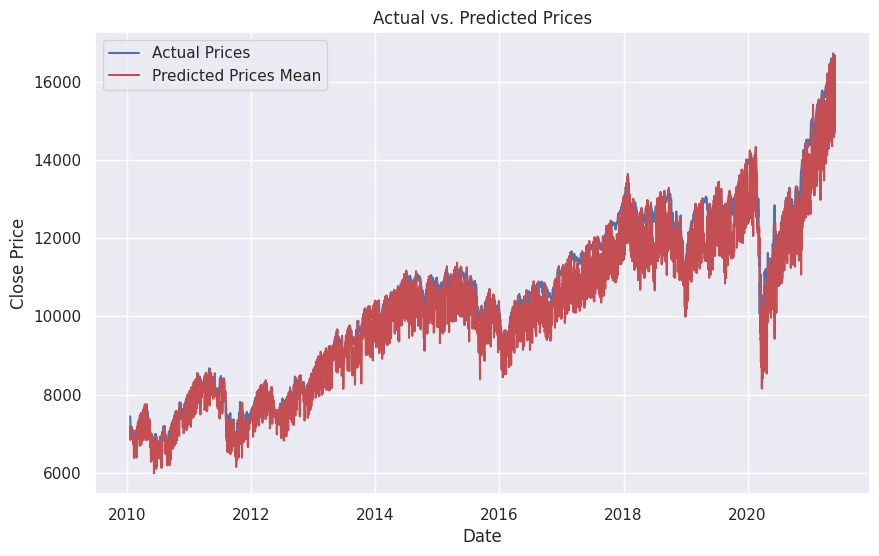

R2 Score: 0.8937467287811691
Mean Squared Error: 516024.37267255114


In [ ]:
r2, mse = evaluate_and_plot_lstm_model(lstm_model, testing_data['Close'].to_numpy(), 10, 1, testing_data)


# 3.Project Conclusion
In this project, we embarked on a journey to explore the predictive capabilities of various machine learning and deep learning models for stock price forecasting. Utilizing a rich dataset, we applied a suite of techniques ranging from basic statistical models to advanced neural networks, emphasizing the power of Long Short-Term Memory (LSTM) models for time-series analysis.

Through rigorous experimentation, we discovered that while traditional models like Linear Regression and Decision Trees provide a solid baseline, deep learning models, particularly those employing LSTM networks, offer superior precision in capturing the complex patterns of stock market movements. The integration of TensorFlow and Keras facilitated the construction and tuning of our models, enabling us to navigate through the intricate dynamics of financial data with increased accuracy.

Our visualizations, powered by Matplotlib and Seaborn, not only illustrated the predictive performance of our models but also provided valuable insights into the underlying trends and volatilities of the stock market. The customization of plot sizes ensured that our findings were presented clearly and effectively, enhancing the interpretability of our results.

As we conclude, it's evident that the field of stock price prediction is both challenging and rewarding. The advancements in machine learning and deep learning open new avenues for research and application. Moving forward, we aim to explore more sophisticated models, delve deeper into feature engineering, and incorporate external factors such as economic indicators and news sentiment to enhance our predictive capabilities. Our journey through data, models, and insights paves the way for future explorations in the fascinating world of financial analytics.